# Predicting Jeopardy! Categories Using the Bag of Words Method: Two Categories

In this notebook, I will look at a collection of clues and related data from the game show Jeopardy!. I will attempt to predict the category of a clue based on the clue text using the bag of words method.

I will consider only two categories. I will try a few different classifiers and compare them using ROC and AUC.

This data is available at https://blog.cambridgespark.com/50-free-machine-learning-datasets-natural-language-processing-d88fb9c5c8da

## Data Preprocessing

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for bag of words and classifiers
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Import libraries to evaluate models
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import metrics

In [2]:
# Import data file
df = pd.read_csv('JEOPARDY_CSV.csv')

In [3]:
# View top five rows
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


I received an error when trying to look into the column details, so I printed the column names and saw that several have an extra space.

In [4]:
# Print column names
print(df.columns.tolist())

['Show Number', ' Air Date', ' Round', ' Category', ' Value', ' Question', ' Answer']


In [5]:
# Remove the extra space from the column names
df.columns = df.columns.str.strip()

In Jeopardy!, the answers are in the form of questions, so the 'Question' column should be called 'Clue' instead.

In [6]:
# Rename the 'Question' column as 'Clue'
df.rename(columns={'Question': 'Clue'}, inplace=True)

In [7]:
# Number of occurrences of each value in Category
df['Category'].value_counts()

BEFORE & AFTER                 547
SCIENCE                        519
LITERATURE                     496
AMERICAN HISTORY               418
POTPOURRI                      401
                              ... 
1970s TELEVISION                 1
RENAISSANCE LITERATURE           1
EMMY WINNERS                     1
THE ENCYCLOPEDIA BRITANNICA      1
U.S. TRANSPORTATION HISTORY      1
Name: Category, Length: 27995, dtype: int64

I'll keep two of the most frequent categories: Science and Literature.

In [8]:
# Keep only those rows for which the value of Category is Science or Literature
df = df.loc[df['Category'].isin(['SCIENCE', 'LITERATURE'])]

In [9]:
# Check that only Science and Literature are present in the Category column
df['Category'].unique()

array(['SCIENCE', 'LITERATURE'], dtype=object)

In [10]:
# Create a dataframe with only the 'Clue' and 'Category' columns
df_nlp = df[['Clue','Category']]

# Split the data into Clue and Answer (which is the target)
X0, y = df_nlp.iloc[:,0], df_nlp.iloc[:,1]

I need to clean the text of the clues. Some clues include web links, which need to be removed. I will also remove special characters and make all text lower-case.

In [11]:
# Remove web links
X0 = X0.str.replace(r'http\S+', '')

# Remove special characters
X0 = X0.str.replace('[^A-Za-z0-9]+', ' ')

# Make all text lower-case
X0 = X0.str.lower()

# Remove leading spaces
X = X0.str.strip()

## Create the Bag of Words

In [12]:
# Use the NLTK English stop words
stop_words = nltk.corpus.stopwords.words('english')

# Add some stop words which appear frequently in the clues
new_stop_words = ('one', 'two', 'three', 'four', 'first', 'second', 'third', 'clue', 'crew', 'target', 'blank', 'sub', 
                  'called', 'call', 'named', 'name', 'u', 'use', 'used')

# Join the two lists of stop words together
total_stop_words = list(set().union(stop_words,new_stop_words))

In [13]:
# Define and fit the count vectorizer
vectorizer = CountVectorizer(max_features=6000, stop_words=total_stop_words)
X = vectorizer.fit_transform(X).toarray()

# Define and fit the Tfid transformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Random Forest Classifier

In [14]:
# Use GridSearchCV to find best values for n_estimators for Random Forest Classifier
parameter = {'n_estimators' : [100, 200, 300, 400]}

RFC = RandomForestClassifier()
RFC_CV = GridSearchCV(RFC, parameter).fit(X_train, y_train)
RFC_CV.best_params_

{'n_estimators': 100}

In [15]:
# Define and fit random forest classifier
RF_classifier = RandomForestClassifier(n_estimators=100, random_state=0)
RF_classifier.fit(X_train, y_train) 

# Predict values with random forest classifier
RF_y_pred = RF_classifier.predict(X_test)

# Predict probabilities with random forest classifier
RF_y_pred_proba = RF_classifier.predict_proba(X_test)

In [16]:
# Print the random forest confusion matrix
print ('Random Forest Confusion Matrix\n')
print(confusion_matrix(y_test, RF_y_pred))

Random Forest Confusion Matrix

[[ 82  15]
 [  4 102]]


This means that 82 items in the test set were correctly classified as Literature, 102 were correctly classified as Science, 15 were misidentified as Science, and 4 were misidentified as Literature.

In [17]:
# Print the random forest classification report
print ('Random Forest Classification Report\n')
print(classification_report(y_test, RF_y_pred))

Random Forest Classification Report

              precision    recall  f1-score   support

  LITERATURE       0.95      0.85      0.90        97
     SCIENCE       0.87      0.96      0.91       106

    accuracy                           0.91       203
   macro avg       0.91      0.90      0.91       203
weighted avg       0.91      0.91      0.91       203



Overall, 91% of all classifications were correct. Literature has a high precision, with 95% of the test set classified as Literature clues actually being Literature clues. The recall for Literature is lower, meaning that 85% of the test set Literature clues were correctly classified.

For Science, the recall is higher than the precision.

## Logistic Regression

In [18]:
# Define and fit logistic regression
LR = LogisticRegression()
LR.fit(X_train, y_train)

# Predict values with logistic regression 
LR_y_pred = LR.predict(X_test)

# Predict probabilities with logistic regression
LR_y_pred_proba = LR.predict_proba(X_test)

In [19]:
# Print the logistic regression confusion matrix
print ('Logistic Regression Confusion Matrix\n')
print(confusion_matrix(y_test, LR_y_pred))

Logistic Regression Confusion Matrix

[[ 84  13]
 [  3 103]]


This means that 84 items in the test set were correctly classified as Literature, 103 were correctly classified as Science, 13 were misidentified as Science, and 3 were misidentified as Literature.

In [20]:
# Print the logistic regression classification report
print ('Logistic Regression Classification Report\n')
print(classification_report(y_test, LR_y_pred))

Logistic Regression Classification Report

              precision    recall  f1-score   support

  LITERATURE       0.97      0.87      0.91        97
     SCIENCE       0.89      0.97      0.93       106

    accuracy                           0.92       203
   macro avg       0.93      0.92      0.92       203
weighted avg       0.93      0.92      0.92       203



Overall, 92% of all classifications were correct. Literature has a high precision, with 97% of the test set classified as Literature clues actually being Literature clues. The recall for Literature is lower, meaning that 87% of the test set Literature clues were correctly classified.

For Science, the recall is higher than the precision.

## KNN Classifier

In [21]:
# Define and fit KNN classifier
KNN_classifier = KNeighborsClassifier(n_neighbors=4)
KNN_classifier.fit(X_train, y_train)

# Predict values with KNN classifier
KNN_y_pred = KNN_classifier.predict(X_test)

# Predict probabilities with KNN classifier
KNN_y_pred_proba = KNN_classifier.predict_proba(X_test)

In [22]:
# Print KNN confusion matrix
print ('KNN Confusion Matrix\n')
print(confusion_matrix(y_test, KNN_y_pred))

KNN Confusion Matrix

[[90  7]
 [19 87]]


This means that 90 items in the test set were correctly classified as Literature, 87 were correctly classified as Science, 7 were misidentified as Science, and 19 were misidentified as Literature.

In [23]:
# Print KNN classification report
print ('KNN Classification Report\n')
print(classification_report(y_test, KNN_y_pred))

KNN Classification Report

              precision    recall  f1-score   support

  LITERATURE       0.83      0.93      0.87        97
     SCIENCE       0.93      0.82      0.87       106

    accuracy                           0.87       203
   macro avg       0.88      0.87      0.87       203
weighted avg       0.88      0.87      0.87       203



Overall, 87% of all classifications were correct. Literature has a high recall, meaning 93% of the test set Literature clues were correctly classified. The precision for Literature is lower, meaning that 83% of the test set classified as Literature clues were actually Literature clues.

For Science, the precision is higher than the recall.

## Receiver Operating Characteristic (ROC) and Area Under Curve (AUC)

In [24]:
# Define false positive rate, true positive rate, and AUC (to three decimal places) for random forest
RF_fpr, RF_tpr, _ = metrics.roc_curve(y_test,  RF_y_pred_proba[:,1], pos_label='SCIENCE')
RF_auc = "{:.3f}".format(metrics.roc_auc_score(y_test, RF_y_pred_proba[:,1]))

# Define false positive rate, true positive rate, and AUC (to three decimal places) for logistic regression
LR_fpr, LR_tpr, _ = metrics.roc_curve(y_test,  LR_y_pred_proba[:,1], pos_label='SCIENCE')
LR_auc = "{:.3f}".format(metrics.roc_auc_score(y_test, LR_y_pred_proba[:,1]))

# Define false positive rate, true positive rate, and AUC (to three decimal places) for KNN
KNN_fpr, KNN_tpr, _ = metrics.roc_curve(y_test,  KNN_y_pred_proba[:,1], pos_label='SCIENCE')
KNN_auc = "{:.3f}".format(metrics.roc_auc_score(y_test, KNN_y_pred_proba[:,1]))

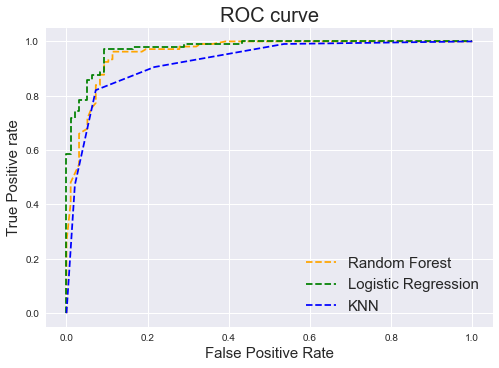

In [25]:
# Plot ROC curves
plt.style.use('seaborn')
plt.plot(RF_fpr, RF_tpr, linestyle='--',color='orange', label='Random Forest')
plt.plot(LR_fpr, LR_tpr, linestyle='--',color='green', label='Logistic Regression')
plt.plot(KNN_fpr, KNN_tpr, linestyle='--',color='blue', label='KNN')
plt.title('ROC curve',fontsize=20)
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive rate',fontsize=15)
plt.legend(loc='best',fontsize=15)
plt.show();

In [26]:
# Print random forest AUC
print(f'Random Forest AUC: {RF_auc}')

Random Forest AUC: 0.960


In [27]:
# Print logistic regression AUC
print(f'Logistic Regression AUC: {LR_auc}')

Logistic Regression AUC: 0.975


In [28]:
# Print KNN AUC
print(f'KNN AUC: {KNN_auc}')

KNN AUC: 0.927


From the ROC curves and the AUC scores, the Logistic Regression performs the best in this case. This is also supported by the overall accuracy scores and the F1-scores in the classification reports.